In [3]:
import numpy as np
import pandas as pd
import multiprocessing as mp
from inspect import signature
from matplotlib import pyplot as plt
from dacbench.logger import Logger, log2dataframe, load_logs
import seaborn as sns
import glob
from plotting import _plot_performance_over_time, plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave
#from plotting import plot_performance_over_time, plot_final_performance_comparison, plot_improvement_probability, plot_configuration_footprint, plot_hp_importance, plot_deepcave

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/envs/__init__.py:35: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/dacbench/benchmarks/__init__.py:26: UserWarning: CMA-ES Benchmark not installed. If you want to use this benchmark, please follow the installation guide.
  warnings.warn(  # noqa: B028


DACBench Gym registration failed - make sure you have all dependencies installed and their instance sets in the right path!


In [4]:
def toDataFrame(glob_path, col_name, col_index, method=None):
    d =  [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    df['epoch'] = df.index + 1
    df = df.melt(id_vars=['epoch'])
    df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        df['method'] = method

    return df

def toChunkedDataFrame(glob_path, col_name, col_index, chunk_size, method=None):
    d = [log2dataframe(load_logs(path)) for path in glob.glob(glob_path)]
    
    # Create a DataFrame where each column is the series of values from a run.
    df = pd.DataFrame([s[col_name][col_index] for s in d]).transpose()
    
    result_df = pd.DataFrame()
    for col in df.columns:
        arr = df[col].values
        n = len(arr)
        remainder = n % chunk_size
        # If the length isn't a multiple of chunk_size, pad it.
        if remainder != 0:
            pad_length = chunk_size - remainder
            # Use the mean of the last (incomplete) chunk for padding.
            pad_value = arr[-remainder:].mean()
            padded_arr = np.concatenate([arr, np.full(pad_length, pad_value)])
        else:
            padded_arr = arr
        reshaped_data = padded_arr.reshape(-1, chunk_size)
        result_df[col] = reshaped_data.mean(axis=1)
    
    result_df.reset_index(drop=True, inplace=True)
    result_df['epoch'] = result_df.index + 1
    result_df = result_df.melt(id_vars=['epoch'])
    result_df.rename(columns={'variable': 'seed'}, inplace=True)
    
    if method:
        result_df['method'] = method
    
    return result_df

def get_final_labels_and_stats(data, epoch_col="epoch", value_col="value", group_col="method",
                               label_format="{label} ({mean:.3f} SE {sem:.3f})"):
    """
    Computes final aggregated stats and creates new legend labels, preserving the original order.

    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame containing the data with columns for epoch, value, and group identifier.
    epoch_col : str, default "epoch"
        Column name representing the epoch.
    value_col : str, default "value"
        Column name for the metric values.
    group_col : str, default "method"
        Column name used to group the data.
    label_format : str, default "{label}: {mean:.3f} ± {sem:.3f}"
        A format string used to create new legend labels, where {label} is the group,
        {mean} is the computed mean, and {sem} is the standard error.

    Returns:
    --------
    new_labels : list of str
        A list of updated legend labels with the final aggregated values in the original order.
    final_stats : pd.DataFrame
        A DataFrame indexed by the group column containing the mean and standard error,
        reindexed to preserve the original order of appearance.
    """
    # Determine the final epoch
    final_epoch = data[epoch_col].max()

    # Filter data to only include the final epoch
    final_data = data[data[epoch_col] == final_epoch]

    # Compute aggregated statistics (mean and standard error) grouped by the given group column
    final_stats = final_data.groupby(group_col)[value_col].agg(["mean", "sem"])

    # Get the original order of methods as they first appear in the data
    original_order = data[group_col].drop_duplicates().tolist()

    # Reindex final_stats to follow the original order (dropping any methods that might be missing)
    final_stats = final_stats.reindex(original_order)

    # Create new labels in the preserved order
    new_labels = []
    for label in original_order:
        if label in final_stats.index and pd.notnull(final_stats.loc[label, "mean"]):
            new_label = label_format.format(label=label,
                                            mean=final_stats.loc[label, "mean"],
                                            sem=final_stats.loc[label, "sem"])
        else:
            new_label = label
        new_labels.append(new_label)
    
    return new_labels


# sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
palette = sns.color_palette([palette[0], palette[8], palette[6], palette[9], palette[7]])
# sns.set_palette(palette)
sns.set_context("notebook", font_scale=1.15)

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


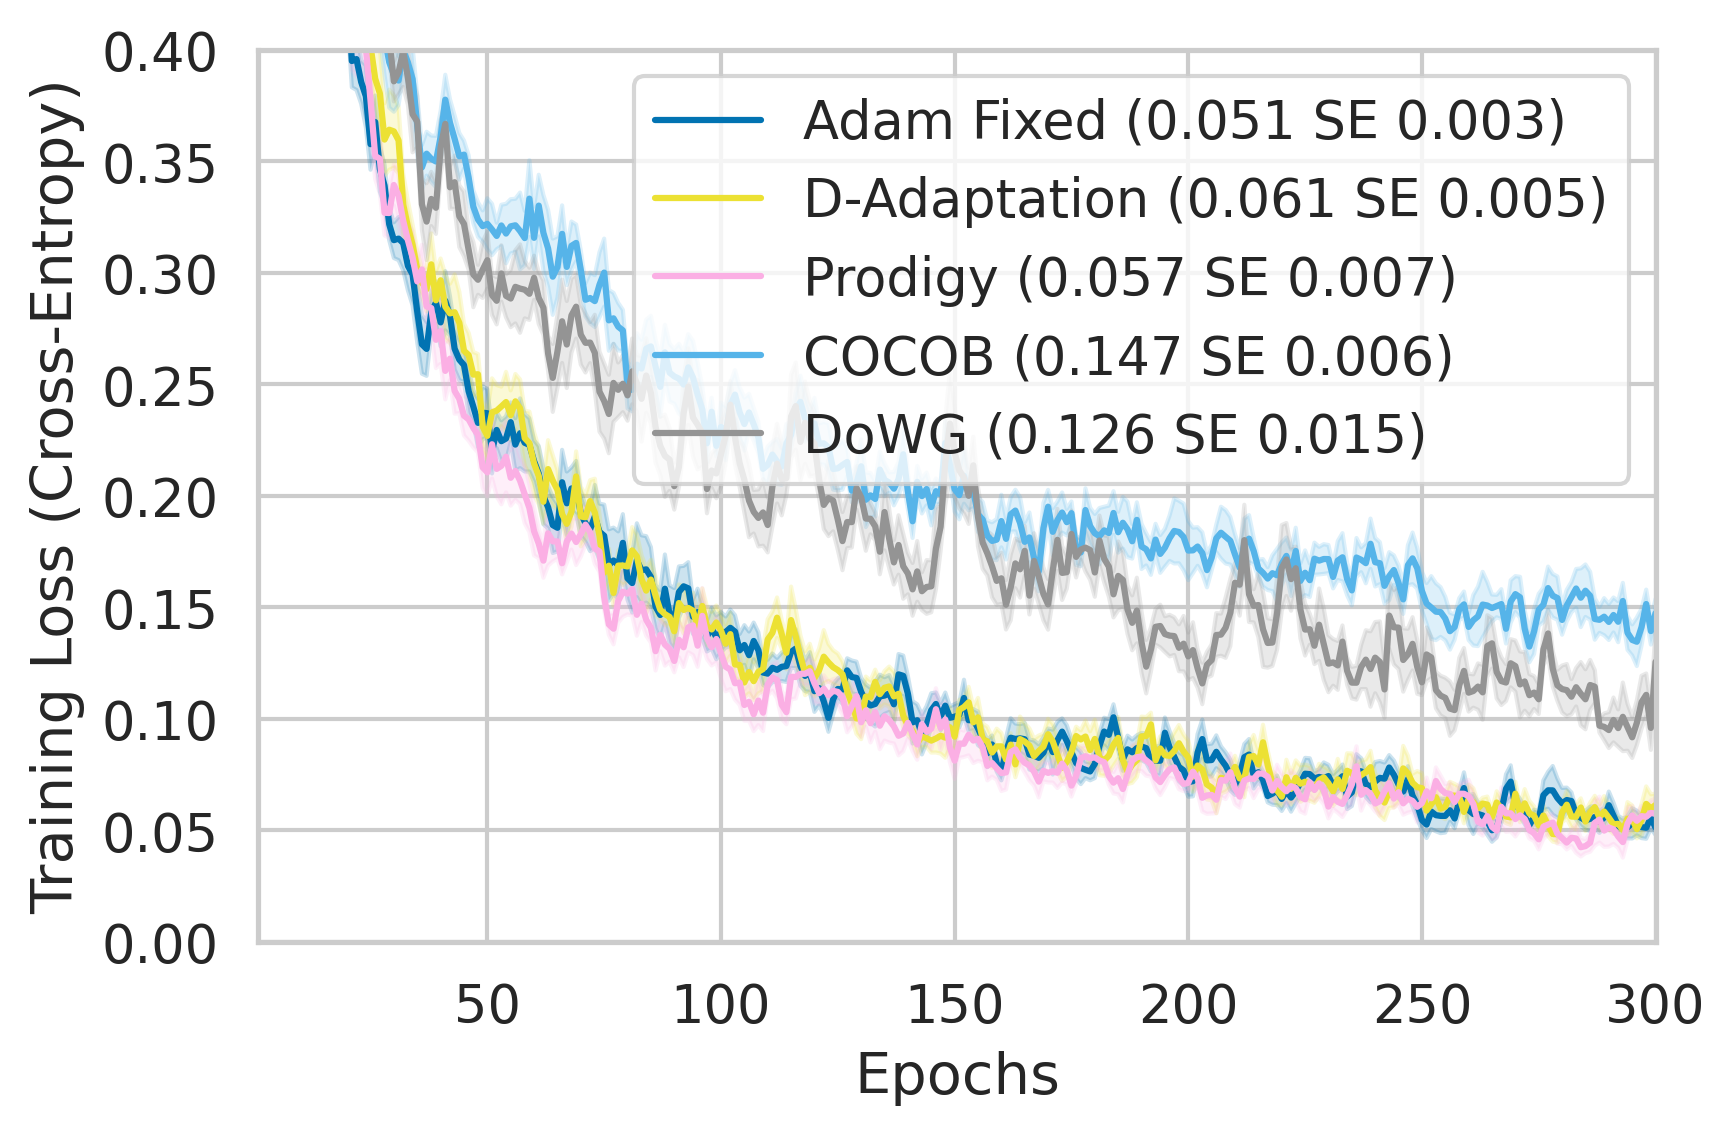

In [5]:
cocob_tl = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='COCOB')
dadaptation_tl = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='D-Adaptation')
prodigy_tl = toDataFrame('../results_cluster/results/prodigy_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, method='Prodigy')
adam_fixed_tl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 'Adam Fixed')
dowg_tl = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'training_losses', 3, 'DoWG')

# 'seed', 'epoch', 'method', 'training_loss'

data = pd.concat([adam_fixed_tl, dadaptation_tl, prodigy_tl, cocob_tl, dowg_tl], ignore_index=True)
data['value'] = data.groupby(['method', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
fig = _plot_performance_over_time(
    data,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    errorbar='se',
    logy=False,
    xlabel="Epochs",
    ylabel="Training Loss (Cross-Entropy)",
    ylim=(0, 0.4),
    palette=palette,
    )
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, _ = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, get_final_labels_and_stats(data), loc="upper right", bbox_to_anchor=(1, 1),
          ncol=1, title=None, frameon=True)

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


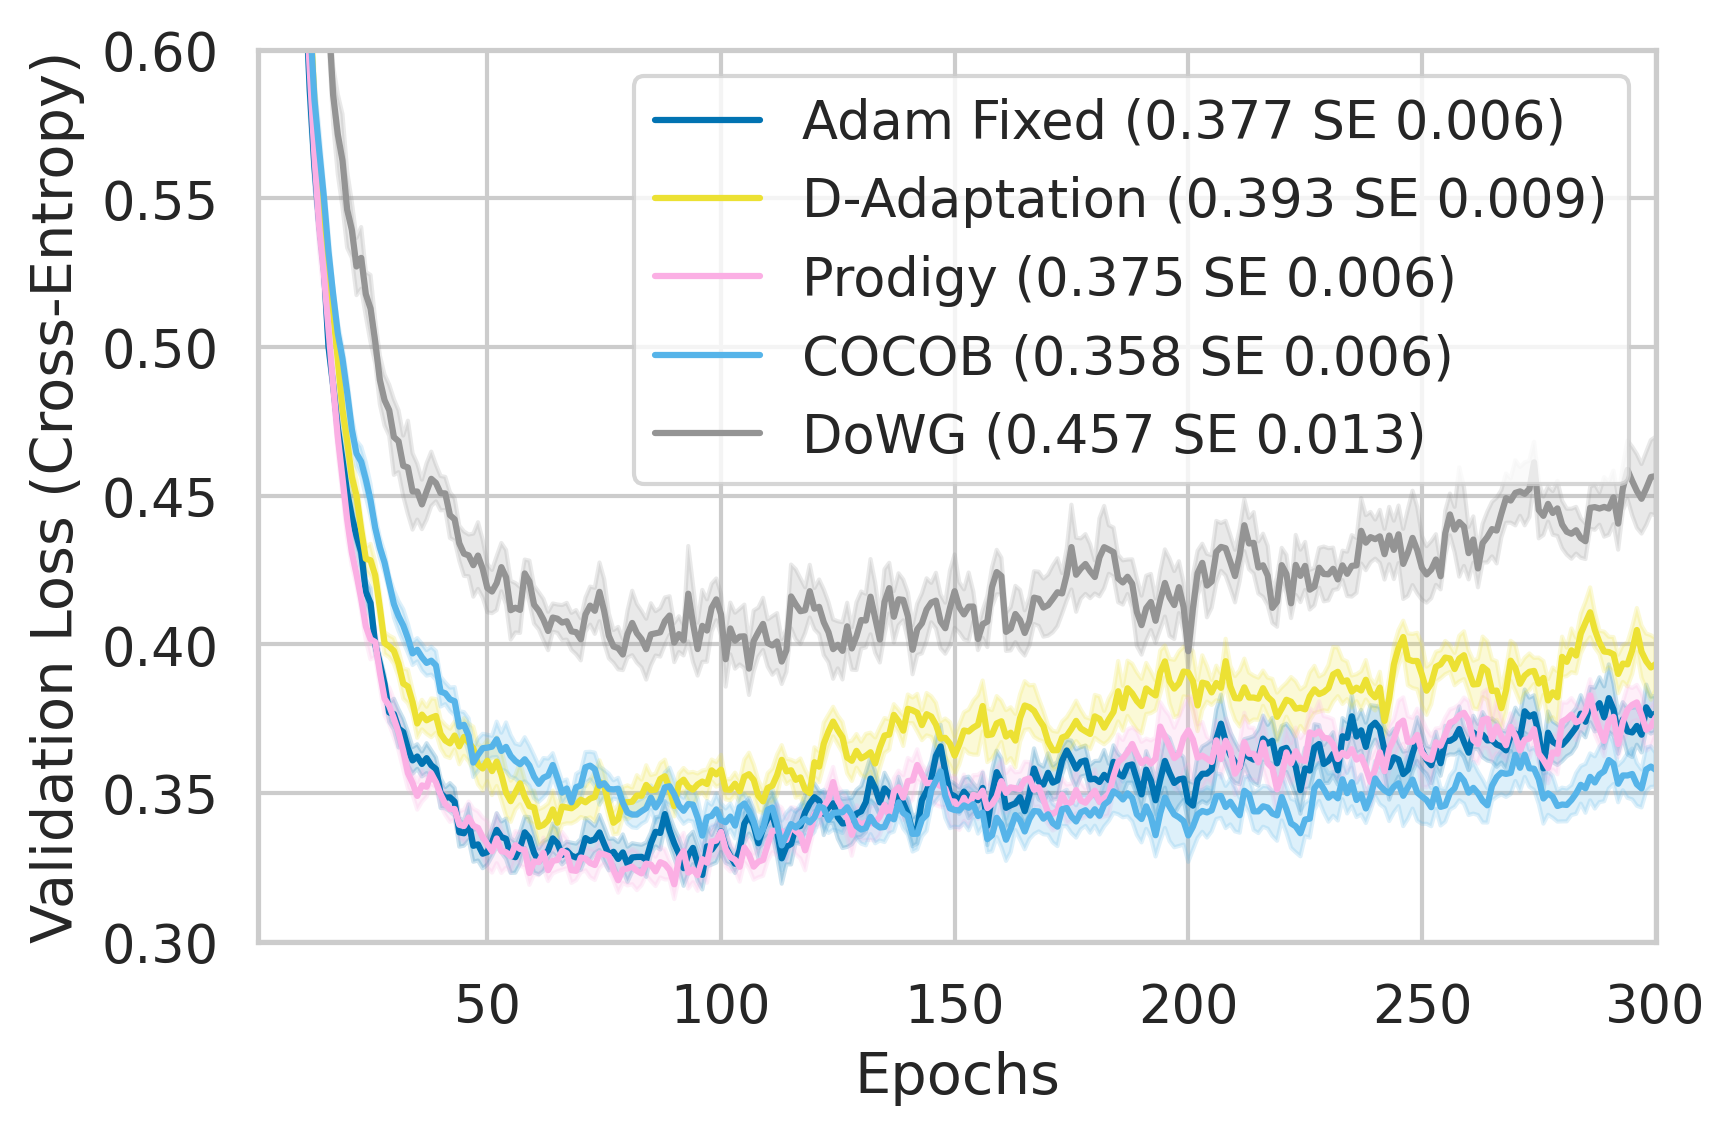

In [6]:
cocob_vl = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='COCOB')
dadaptation_vl = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='D-Adaptation')
prodigy_vl = toDataFrame('../results_cluster/results/prodigy_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, method='Prodigy')
adam_fixed_vl = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'Adam Fixed')
dowg_vl = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_losses', 5, 'DoWG')

# 'seed', 'epoch', 'method', 'training_loss'

data = pd.concat([adam_fixed_vl, dadaptation_vl, prodigy_vl, cocob_vl, dowg_vl], ignore_index=True)
data['value'] = data.groupby(['method', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
fig = _plot_performance_over_time(
    data,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    errorbar="se",
    logy=False,
    xlabel="Epochs",
    ylabel="Validation Loss (Cross-Entropy)",
    ylim=(0.3,0.6),
    palette=palette)
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, _ = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, get_final_labels_and_stats(data), loc="upper right", bbox_to_anchor=(1, 1),
          ncol=1, title=None, frameon=True)

/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/micha/anaconda3/envs/PFDAC/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


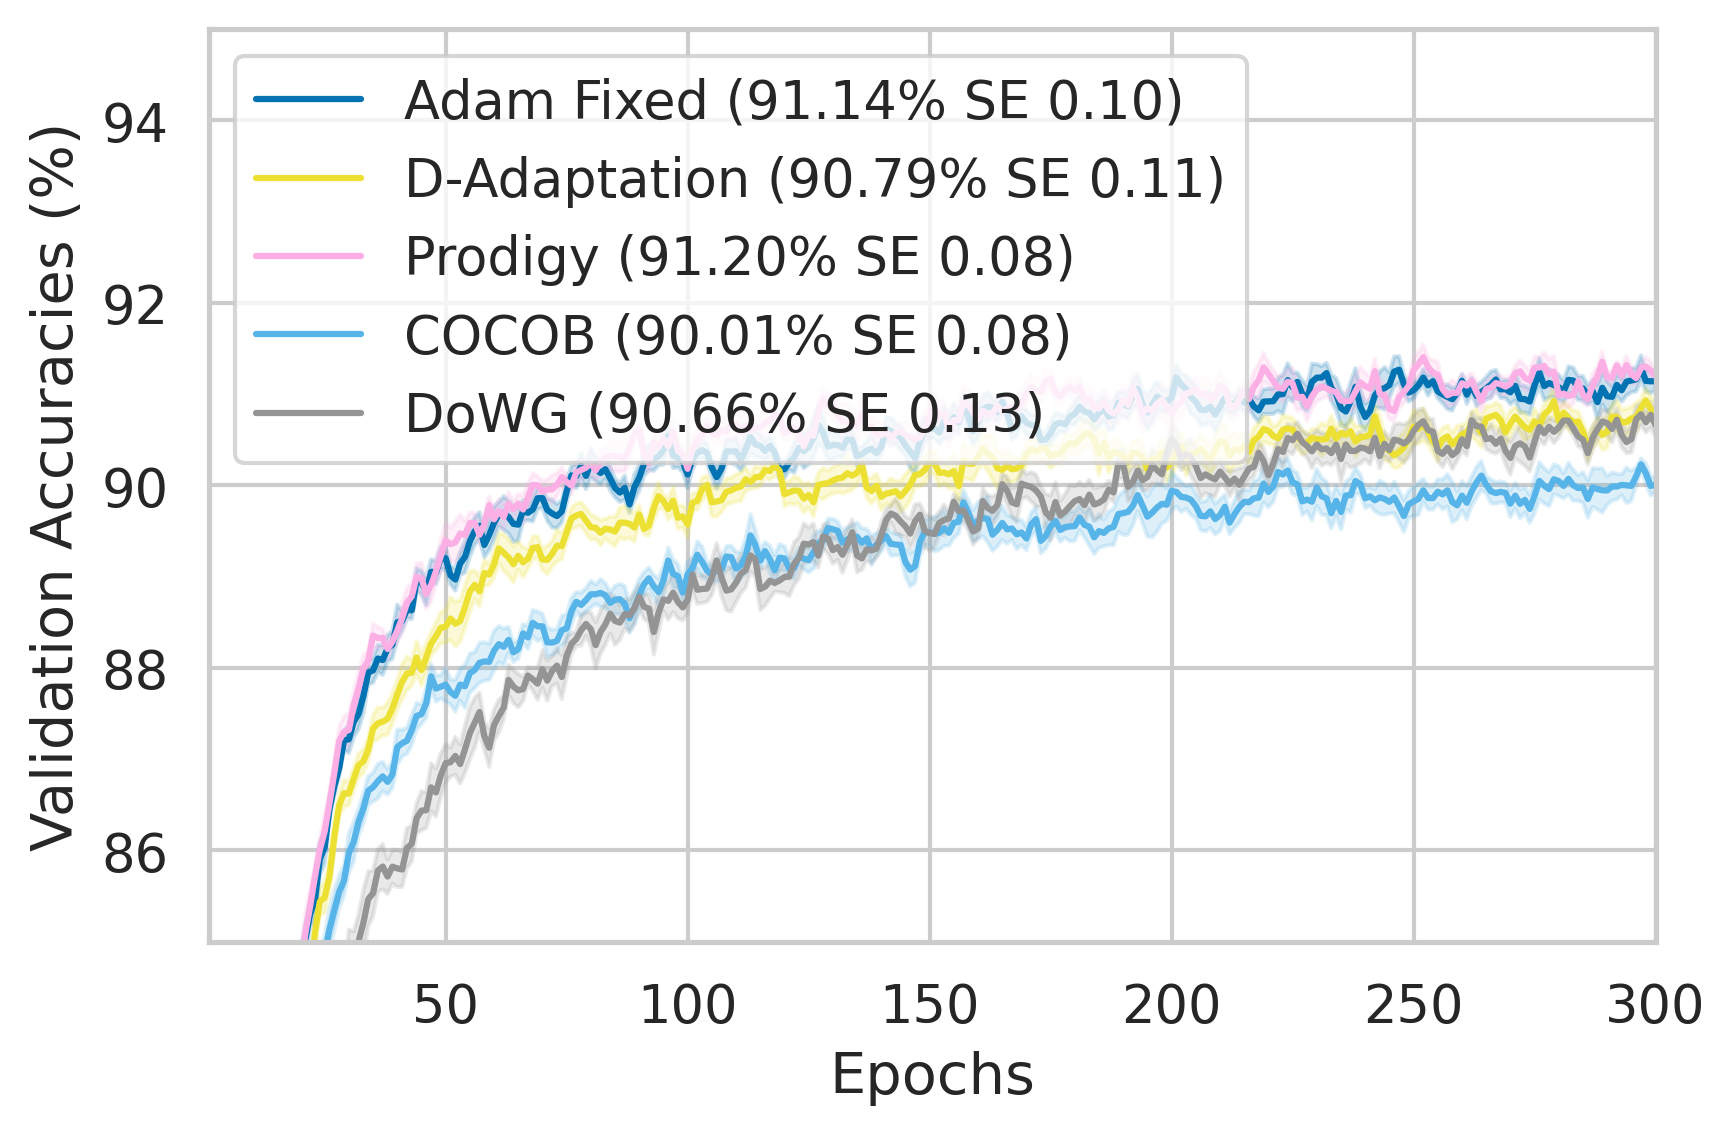

In [7]:
cocob_va = toDataFrame('../results_cluster/results/COCOB_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='COCOB')
dadaptation_va = toDataFrame('../results_cluster/results/dadaptation_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='D-Adaptation')
prodigy_va = toDataFrame('../results_cluster/results/prodigy_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, method='Prodigy')
adam_fixed_va = toDataFrame('../results_cluster/results/Adam_fixed_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'Adam Fixed')
dowg_va = toDataFrame('../results_cluster/results/DoWG_cifar10/*/CustomTrackingWrapper.jsonl', 'validation_accuracies', 6, 'DoWG')

# 'seed', 'epoch', 'method', 'training_loss'

data = pd.concat([adam_fixed_va, dadaptation_va, prodigy_va, cocob_va, dowg_va], ignore_index=True)
data['value'] = data.groupby(['method', 'seed'])['value'] \
                        .transform(lambda x: x.ewm(alpha=0.3, adjust=False).mean())
data['value'] = data['value'] * 100 # convert to percent
fig = _plot_performance_over_time(
    data,
    x="epoch",
    y="value",
    hue="method",
    aggregation="mean",
    logy=False,
    xlabel="Epochs",
    ylabel="Validation Accuracies (%)",
    ylim=(85, 95),
    errorbar="se",
    palette=palette)
fig.set_size_inches(6, 4, forward=True)
fig.gca().set_title("")
handles, _ = fig.gca().get_legend_handles_labels()
fig.gca().legend(handles, get_final_labels_and_stats(data, label_format="{label} ({mean:.2f}% SE {sem:.2f})"), loc="upper left", bbox_to_anchor=(0, 1),
          ncol=1, title=None, frameon=True)